In [47]:
import pandas as pd
import numpy as np
import string
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objs as go
import matplotlib.patches as mpatches

# plotly output mode
py.offline.init_notebook_mode(connected=True)
# matplotlib display in notebook
% matplotlib inline
# seaborn style
sns.set(style='whitegrid', palette='muted', color_codes=True)


<script>requirejs.config({paths: { 'plotly': ['https://cdn.plot.ly/plotly-latest.min']},});if(!window.Plotly) {{require(['plotly'],function(plotly) {window.Plotly=plotly;});}}</script>

In [3]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer

from sklearn.utils.validation import check_X_y


In [4]:
stopwords_set = set(stopwords.words('english'))
s = PorterStemmer()
tokenizer = RegexpTokenizer(r'\w+')

def text_process(comment_column):
    filtered_rows = []
    for rows in comment_column:
        only_words = tokenizer.tokenize(rows)
        no_stopwords = [word for word in only_words if word.lower() not in stopwords_set]
        #stems = [s.stem(word) for word in no_stopwords]
        filtered_rows.append(' '.join(no_stopwords))
    return filtered_rows

def find_badwords(comment_column):
    filtered_rows = []
    for rows in comment_column:
        only_words = tokenizer.tokenize(rows)
        bad = [word for word in only_words if word.lower() in badwords_set]
        total_bad, = np.shape(bad)
        filtered_rows.append(total_bad)
    return filtered_rows

def get_tags(df):
    tags = []
    alltags = []
    rows = df.shape[0]
    for r in range(df.index.min(), df.index.max() + 1):
        for f in df.columns:
            if df.loc[r, f] == 1:
                tags.append(str(f))
        alltags.append(tags)
        tags = []
    return alltags


In [5]:
df_train_initial = pd.read_csv('data/raw/train.csv.zip')
df_test_initial = pd.read_csv('data/raw/test.csv.zip')
df_features = pd.concat([df_train_initial, df_test_initial]).reset_index(drop=True)
df_features["source"] = ''
df_features.loc[0:len(df_train_initial), ['source']] = 'train'
df_features.loc[len(df_train_initial):, ['source']] = 'test'

initialcols = list(df_train_initial.columns[df_train_initial.dtypes == 'int64'])

punct_set = set(string.punctuation)

badwords = pd.read_csv('data/external/badwords.txt', header=None)
badwords.rename(columns={0: 'badwords'}, inplace=True)
badwords['badwords'] = badwords['badwords'].str.lower()
badwords_set = set(badwords['badwords'].str.replace('*', ''))


No nulls in data set

In [6]:
df_train_initial.isna().sum()


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Indicate whether a row is 'clean' and how many flags it has

In [7]:
df_features['clean'] = df_features.loc[:, initialcols].sum(axis=1).apply(lambda x: 1 if x == 0 else 0)
df_features['total_flags'] = df_features.loc[:, initialcols].sum(axis=1)
df_features['comment_length'] = df_features.comment_text.str.len()


In [53]:
word_count = []
comments_processed = text_process(df_features.comment_text)
word_count_proc = []
comment_len_proc = []
words_all_caps = []
punct_count = []
badword_count = []
badword_allcaps = []
most_common_word_count = []
mcw_is_badword = []
exclam_count = []

for row in df_features.comment_text:
    word_count.append(len(row.split()))
    punct_count.append(sum([1 for x in row if x in punct_set]))
    badword_count.append(sum([1 for x in row.lower().split() if x in badwords_set]))
    exclam_count.append(sum([1 for x in row if x == '!']))

for row in comments_processed:
    word_count_proc.append(len(row.split()))
    comment_len_proc.append(len(row))
    words_all_caps.append(np.sum([x.isupper() for x in row.split() if len(x) > 1]))
    badword_allcaps.append(np.sum([x.isupper() for x in row.split() if (len(x) > 1) & (x.lower() in badwords_set)]))
    q = Counter(tokenizer.tokenize(row))
    if len(q) > 0:
        most_common_word_count.append(q.most_common(1)[0][1])
        mcw_is_badword.append(q.most_common(1)[0][0].lower() in badwords_set)
    else:
        most_common_word_count.append(0)
        mcw_is_badword.append(0)

df_features['comment_word_all_caps_processed'] = words_all_caps
df_features['comment_word_count_processed'] = word_count_proc
df_features['comment_length_processed'] = comment_len_proc
df_features['comment_word_count'] = word_count
df_features['comment_punct_count'] = punct_count
df_features['comment_badword_count'] = badword_count
df_features['comment_badword_all_caps_count'] = badword_allcaps
df_features['comment_most_common_word_count'] = most_common_word_count
df_features['comment_mcw_is_badword'] = mcw_is_badword
df_features['comment_exclam_count'] = exclam_count


In [9]:
df_features['mean_word_size_processed'] = df_features.comment_length_processed/df_features.comment_word_count_processed
df_features['mean_word_size'] = df_features.comment_length/df_features.comment_word_count
df_features['punct_pct'] = df_features.comment_punct_count / df_features.comment_length * 100
df_features['badword_pct'] = df_features.comment_badword_count / df_features.comment_word_count_processed * 100
df_features['all_caps_pct'] = df_features.comment_word_all_caps_processed / df_features.comment_word_count_processed * 100
df_features['all_caps_pct_badwords'] = df_features.comment_badword_all_caps_count / df_features.comment_word_all_caps_processed * 100
df_features['mcw_pct'] = df_features.comment_most_common_word_count/df_features.comment_word_count_processed*100

In [10]:
df_melted = df_features[df_features.source == 'train'].melt(
    id_vars=[x for x in df_features.columns if x not in initialcols + ['clean']],
    value_vars=initialcols + ['clean'],
    var_name='flag_type')
df_melted = df_melted[df_melted.value == 1.0]


In [39]:
df_melted.iloc[:,:6].head(10)

,comment_text,id,source,total_flags,comment_length,comment_word_all_caps_processed
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,0002bcb3da6cb337,train,4.0,44,4.0
12,Hey... what is it..\n@ | talk .\nWhat is it......,0005c987bdfc9d4b,train,1.0,319,7.0
16,"Bye! \n\nDon't look, come or think of comming ...",0007e25b2121310b,train,1.0,57,0.0
42,You are gay or antisemmitian? \n\nArchangel WH...,001810bf8c45bf5f,train,4.0,648,1.0
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",00190820581d90ce,train,3.0,40,5.0
44,I'm Sorry \n\nI'm sorry I screwed around with ...,001956c382006abd,train,1.0,319,0.0
51,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,001dc38a83d420cf,train,2.0,124,14.0
55,Stupid peace of shit stop deleting my stuff as...,0020e7119b96eeeb,train,4.0,89,0.0
56,=Tony Sidaway is obviously a fistfuckee. He lo...,0020fd96ed3b8c8b,train,3.0,68,0.0
58,My Band Page's deletion. You thought I was gon...,0021fe88bc4da3e6,train,2.0,1798,0.0


In [12]:

q

Counter({'Stop': 1,
         'already': 1,
         'bullshit': 1,
         'enough': 1,
         'explination': 1,
         'fool': 1,
         'kind': 1,
         'pity': 1,
         'think': 1,
         'welcome': 1,
         'well': 1})

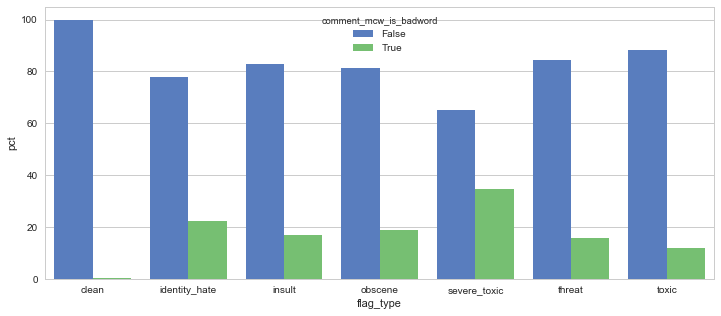

In [13]:
split = 'comment_mcw_is_badword'

q = df_melted.groupby(['flag_type', split]).size().reset_index()
q.columns = ['flag_type', split, 'size']
q = q.merge(df_melted.groupby(['flag_type']).size().reset_index())
q.columns = ['flag_type', split, 'size', 'total_for_flag']
q['pct'] = q['size'] / q['total_for_flag'] * 100
plt.figure(figsize=(12, 5))
sns.barplot(x='flag_type', y='pct', data=q, hue=split)


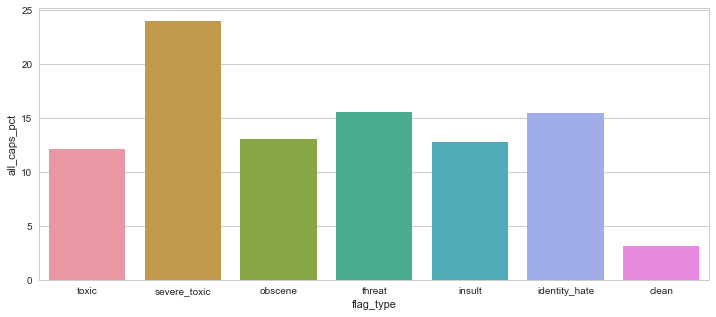

In [14]:
plt.figure(figsize=(12,5))
sns.barplot(x='flag_type',y='all_caps_pct',data=df_melted,ci=None)

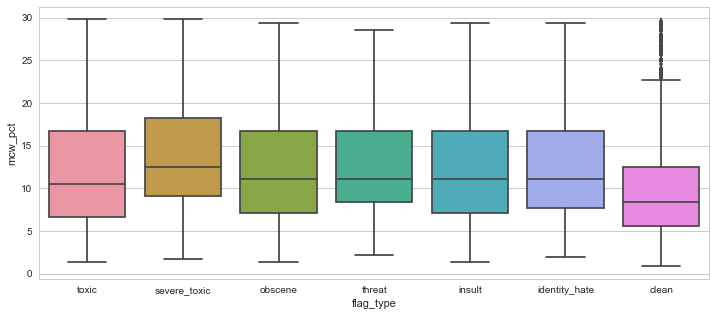

In [15]:
plt.figure(figsize=(12,5))
sns.boxplot(x='flag_type',y='mcw_pct',data=df_melted[df_melted.mcw_pct<30])

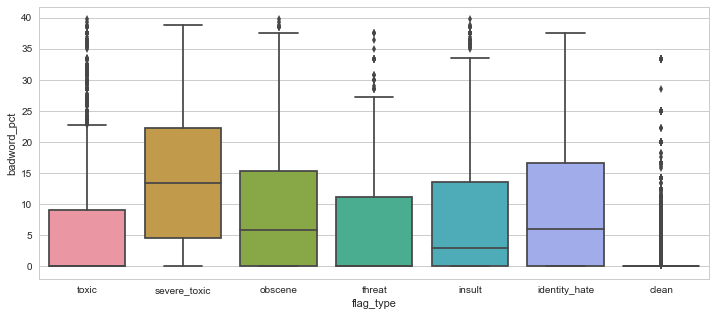

In [16]:
plt.figure(figsize=(12,5))
sns.boxplot(x='flag_type',y='badword_pct',data=df_melted[df_melted.badword_pct<40])

In [52]:
x2 = go.Histogram(x=df_melted[df_melted.flag_type=='toxic'].badword_pct,opacity=.5,name='toxic',
                  histnorm='percent',autobinx=False,xbins=dict(start=0,end=100,size=10))
x5 = go.Histogram(x=df_melted[df_melted.flag_type=='severe_toxic'].badword_pct,opacity=.5,name='severe_toxic',
                  autobinx=False,histnorm='percent',xbins=dict(start=0,end=100,size=10))
x3 = go.Histogram(x=df_melted[df_melted.flag_type=='obscene'].badword_pct,opacity=.5,name='obscene',
                  histnorm='percent',autobinx=False,xbins=dict(start=0,end=100,size=10))
x7 = go.Histogram(x=df_melted[df_melted.flag_type=='threat'].badword_pct,opacity=.5,name='threat',
                  histnorm='percent',autobinx=False,xbins=dict(start=0,end=100,size=10))
x4 = go.Histogram(x=df_melted[df_melted.flag_type=='insult'].badword_pct,opacity=.5,name='insult',
                  histnorm='percent',autobinx=False,xbins=dict(start=0,end=100,size=10))
x6 = go.Histogram(x=df_melted[df_melted.flag_type=='identity_hate'].badword_pct,opacity=.5,name='identity_hate',
                  autobinx=False,histnorm='percent',xbins=dict(start=0,end=100,size=10))
x1 = go.Histogram(x=df_melted[df_melted.flag_type=='clean'].badword_pct,opacity=.5,name='clean',
                  histnorm='percent',autobinx=False,xbins=dict(start=0,end=100,size=10))

data = [x1,x2,x3,x4,x5,x6]
layout = go.Layout(barmode='group',xaxis=dict(range=(0,100)))
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

PlotlyRequestError: You must be authenticated to generate an image via json.

Plot the count of flag types

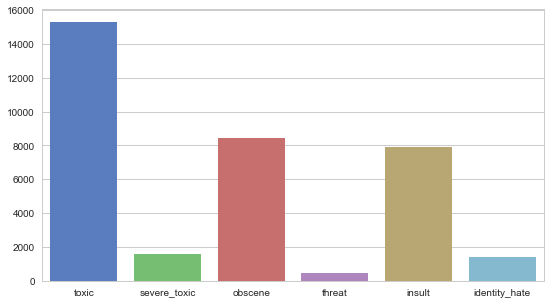

In [17]:
z = df_train_initial.loc[:,initialcols].sum()
plt.figure(figsize=(9,5))
sns.barplot(z.index,z.values)

Plot number of flags per record

why are there more triple flagged records than double flagged?

z = df_train.total_flags.value_counts()
plt.figure(figsize=(9,5))
sns.barplot(z.index,z.values,color='b')


In [19]:
z = pd.DataFrame(df_features.total_flags.value_counts())
z['flags'] = z.index
iplot([go.Bar(x=z.flags, y=z.total_flags)])


<div id="75db7960-4d92-468d-9802-91209af21a06" style="height: 525px; width: 100%;" class="plotly-graph-div"></div><script type="text/javascript">require(["plotly"], function(Plotly) { window.PLOTLYENV=window.PLOTLYENV || {};window.PLOTLYENV.BASE_URL="https://plot.ly";Plotly.newPlot("75db7960-4d92-468d-9802-91209af21a06", [{"type": "bar", "x": [0.0, 1.0, 3.0, 2.0, 4.0, 5.0, 6.0], "y": [143346, 6360, 4209, 3480, 1760, 385, 31]}], {}, {"showLink": true, "linkText": "Export to plot.ly"})});</script>

Plot comment lengths

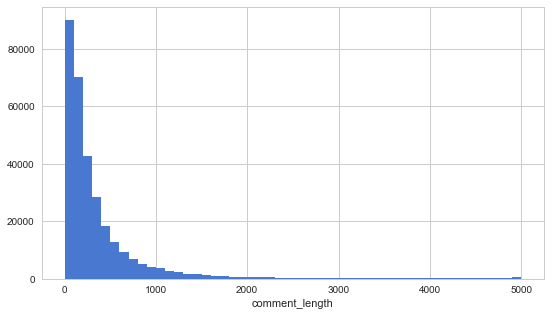

In [20]:
plt.figure(figsize=(9,5))
sns.distplot(df_features.comment_length, color='b', kde=False, hist_kws=dict(alpha=1))

sample comments

In [21]:
print('clean:\n\n',df_features[(df_features.clean==1)].iloc[1,0],'\n........................\n')
print('toxic:\n\n',df_features[(df_features.toxic==1)&(df_features.total_flags==1)].iloc[1,0],'\n........................\n')
print('sever_toxic:\n\n',df_features[(df_features.severe_toxic==1)].iloc[1,0],'\n........................\n')
print('obscene:\n\n',df_features[(df_features.obscene==1)&(df_features.total_flags==1)].iloc[1,0],'\n........................\n')
print('threat:\n\n',df_features[(df_features.threat==1)&(df_features.total_flags==1)].iloc[1,0],'\n........................\n')
print('insult:\n\n',df_features[(df_features.insult==1)&(df_features.total_flags==1)].iloc[1,0],'\n........................\n')
print('identity_hate:\n\n',df_features[(df_features.identity_hate==1)&(df_features.total_flags==1)].iloc[1,0],'\n........................\n')
print('6 flags:\n\n',df_features[(df_features.total_flags==6)].iloc[1,0],'\n........................\n')

clean:

 D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC) 
........................

toxic:

 Bye! 

Don't look, come or think of comming back! Tosser. 
........................

sever_toxic:

 Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell! 
........................

obscene:

 Bleh. I'm all out of ideas. Is there really something wrong with the server or what? The damn thing won't work for me, either Helvetica_font_new.svg (my upload of Segoe UI was actually a PNG to begin with...) 
........................

threat:

 That's funny. You was personally offended? So the bad things writer new you, your name etc, right? 
And one get offended by a comment, or epithets on a website, then that same person must grow up spiritually for some more 5 centuries at least.
And if one get more offended by the previous comment, then that same person must kill him/hersef.

Take care! 
.............

In [22]:
subset=df_features[df_features.clean==1]
text=subset.comment_text.values
wc= WordCloud(colormap='plasma',stopwords=stopwords_set)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(random_state=99), alpha=0.98)
plt.show()

In [23]:
subset=df_features[df_features.total_flags>1]
text=subset.comment_text.values
wc= WordCloud(colormap='plasma',stopwords=stopwords_set)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Multiple Flagged Comments", fontsize=20)
plt.imshow(wc.recolor(random_state=99), alpha=0.98)
plt.show()